In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

In [2]:
# fetch dataset
breast_cancer_data = fetch_ucirepo(id=17) 

# data
X = breast_cancer_data.data.features.values
X_cancer = StandardScaler().fit_transform(X)
y_cancer = np.squeeze(breast_cancer_data.data.targets.values).astype(str)
# y_cancer = np.where(y_cancer == 'M', 1, 0).astype(int)
y_cancer = np.where(y_cancer == 'M', 1, -1).astype(int)

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.2)

# Decision Tree

### Decision Tree with Python library

In [3]:
# applying python library decision tree model to breast cancer data
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train_cancer, y_train_cancer)

y_train_prediction = model.predict(X_train_cancer)
y_test_prediction = model.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9912, Test accuracy: 0.9474

Train recall: 0.9765, Test recall: 0.9524

Train precision: 1.0000, Test precision: 0.9091


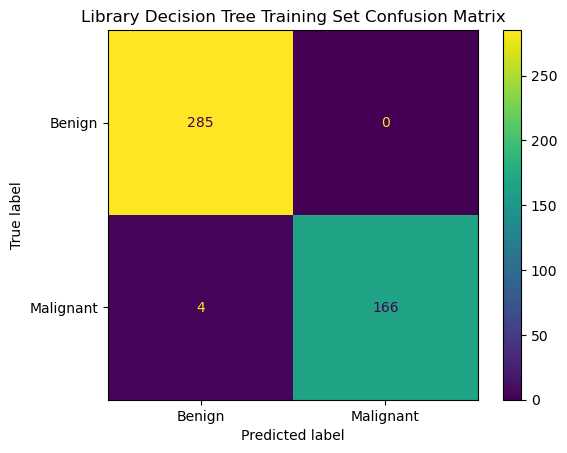

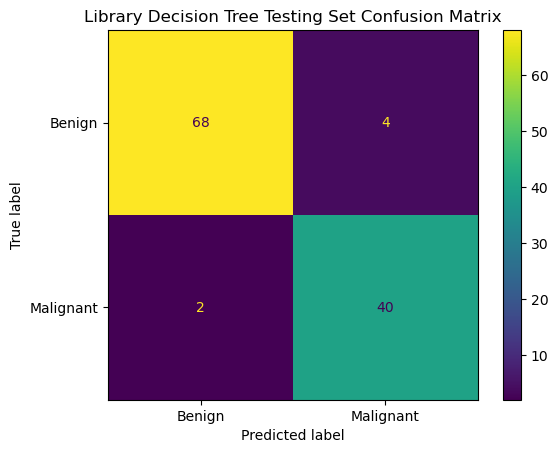

In [4]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Library Decision Tree Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Library Decision Tree Testing Set Confusion Matrix")

plt.show()

### Manual Decision Tree

In [5]:
# creating decision tree for spambase data set
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [6]:
class DecisionTree:
    def __init__(self, min_data_points_in_node=5, max_depth=5, num_features=None, root=None):
        self.min_data_points_in_node = min_data_points_in_node # if number of data points in node are less than the minimum, then don't split node
        self.max_depth = max_depth # max depth of decision tree allowed
        self.num_features = num_features
        self.root = root

    def create_tree(self, X, y, depth=0):
        num_data_points, num_features = X.shape
        num_labels = len(np.unique(y))
        
        # check stopping criteria to create a leaf node
        if depth >= self.max_depth or num_labels == 1 or num_data_points < self.min_data_points_in_node:
            values, counts = np.unique(y, return_counts=True)
            leaf_node_value = values[np.argmax(counts)]
            # leaf_node_value = np.bincount(y).argmax()
            return DecisionTreeNode(value=leaf_node_value)

        feature_indices = np.random.choice(num_features, self.num_features, replace=False)
        
        # find best split
        best_feature, best_threshold = self.best_split(X, y, feature_indices)

        # create child nodes
        left_indices, right_indices = self.split_data(X[:, best_feature], split_threshold=best_threshold)
        left_child = self.create_tree(X[left_indices, :], y[left_indices], depth+1)
        right_child = self.create_tree(X[right_indices, :], y[right_indices], depth+1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def fit(self, X, y):
        if not self.num_features:
            self.num_features = X.shape[1]
        else:
            self.num_features = min(X.shape[1], self.num_features)
        self.root = self.create_tree(X, y)

    def best_split(self, X, y, feature_indices):
        best_gain = -1
        split_index = None
        split_threshold = None

        for feature_index in feature_indices:
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # calculate information gain
                gain = self.calculate_information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    def calculate_information_gain(self, y, X_column, threshold):
        # calculate parent entropy
        parent_entropy = self.calculate_entropy(y)
        
        # create children nodes
        left_indices, right_indices = self.split_data(X_column, threshold)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        
        # calculate weighted average entropy of children nodes
        num_parent_data_points = len(y)
        num_left_data_points = len(left_indices)
        num_right_data_points = len(right_indices)

        entropy_left_side = self.calculate_entropy(y[left_indices])
        entropy_right_side = self.calculate_entropy(y[right_indices])

        children_entropy = (num_left_data_points / num_parent_data_points) * entropy_left_side + (num_right_data_points / num_parent_data_points) * entropy_right_side
    
        # calculate information gain
        information_gain = parent_entropy - children_entropy
        return information_gain

    def calculate_entropy(self, y):
        values, counts = np.unique(y, return_counts=True)
        p_list = counts / len(y)
        # p_list = np.bincount(y) / len(y)
        final_entropy = 0
        for p in p_list:
            if p > 0:
                final_entropy -= p * np.log2(p)
        return final_entropy

    def split_data(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        return left_indices, right_indices
    
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.traverse_tree(x, self.root)
            predictions.append(prediction)
        return np.array(predictions)

    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        else:
            return self.traverse_tree(x, node.right)

In [7]:
# applying manual decision tree model to breast cancer data
model = DecisionTree(max_depth=5)
model.fit(X_train_cancer, y_train_cancer)
y_train_prediction = model.predict(X_train_cancer)
y_test_prediction = model.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9956, Test accuracy: 0.9386

Train recall: 1.0000, Test recall: 1.0000

Train precision: 0.9884, Test precision: 0.8571


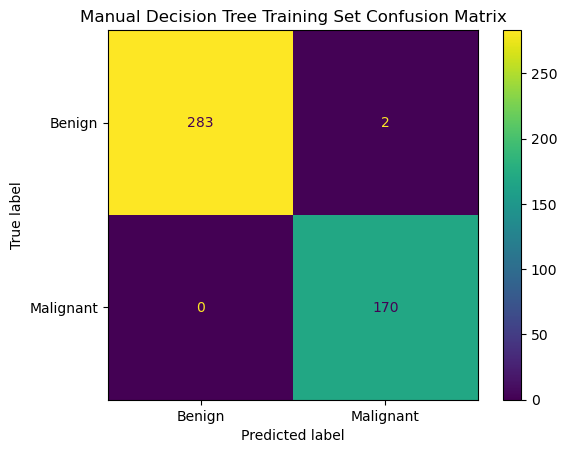

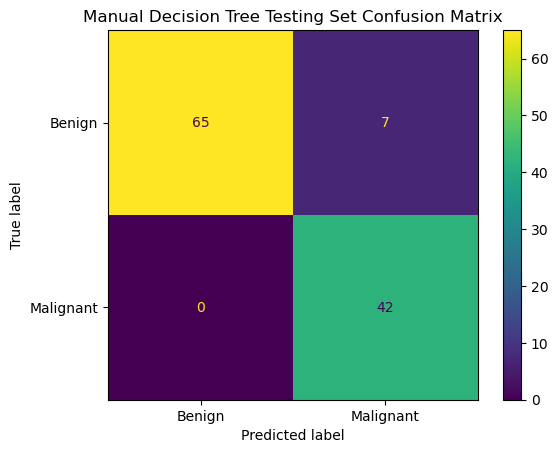

In [8]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Manual Decision Tree Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Manual Decision Tree Testing Set Confusion Matrix")

plt.show()

# Logistic Regression

### Logistic Regression with Python library

In [9]:
# applying python library logistic regression model to breast cancer data
model = LogisticRegression()
model.fit(X_train_cancer, y_train_cancer)
y_train_prediction = model.predict(X_train_cancer)
y_test_prediction = model.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9846, Test accuracy: 1.0000

Train recall: 0.9706, Test recall: 1.0000

Train precision: 0.9880, Test precision: 1.0000


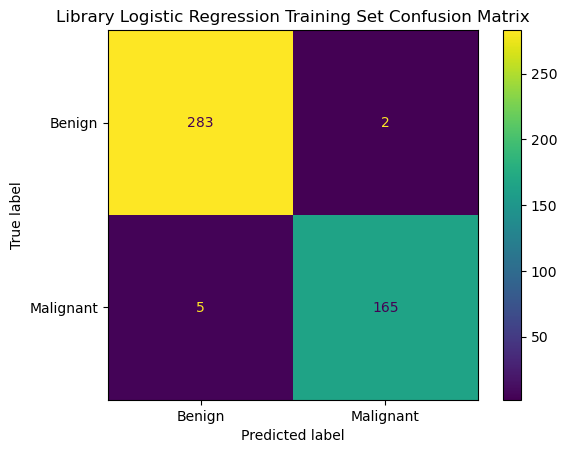

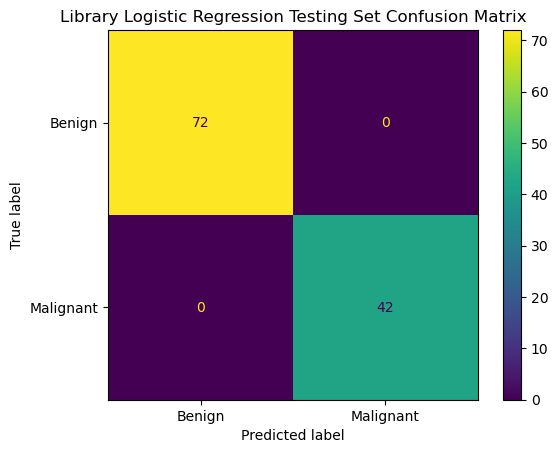

In [10]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Library Logistic Regression Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Library Logistic Regression Testing Set Confusion Matrix")

plt.show()

### Manual Logistic Regression

In [11]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [12]:
class LogisticRegressionGradientDescent():
    def __init__(self, learning_rate=0.001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        num_data_points, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for i in range(self.num_iterations):
            prediction = sigmoid(np.dot(X, self.weights) + self.bias)

            # log likelihood objective, not mean square error
            # h(x_i) = g(x_i * w) = 1 / (1 + e^(-x_i * w + b)
            # LL = sum(y_i * log (g(x_i * w)) + (1 - y_i) * log(1 - g(x_i * w)))
            # want to minimize it by taking derivative of J with respect to w (weights) and b (bias)
            dLL_dw = np.dot(X.T, (prediction - y))
            dLL_db = np.sum(prediction - y)

            # adjust weights and bias for each iteration
            self.weights = self.weights - self.learning_rate * dLL_dw
            self.bias = self.bias - self.learning_rate * dLL_db

    def predict(self, X, threshold=0.5):
        predictions = sigmoid(np.dot(X, self.weights) + self.bias)
        predictions = (predictions > threshold).astype(int)
        predictions[predictions == 0] = -1
        return predictions

In [13]:
# applying manual decision tree model to breast cancer data
learning_rate = 0.001
num_iterations = 10000
logistic_regression_gradient_descent = LogisticRegressionGradientDescent(learning_rate=learning_rate, num_iterations=num_iterations)
logistic_regression_gradient_descent.fit(X_train_cancer, y_train_cancer)
y_train_prediction = logistic_regression_gradient_descent.predict(X_train_cancer)
y_test_prediction = logistic_regression_gradient_descent.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9385, Test accuracy: 0.9561

Train recall: 0.8882, Test recall: 0.9286

Train precision: 0.9437, Test precision: 0.9512


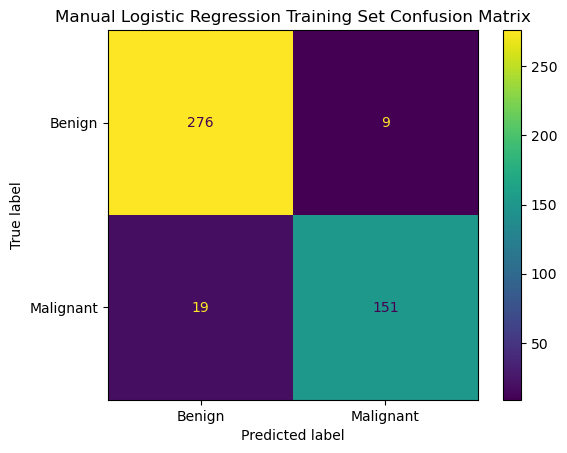

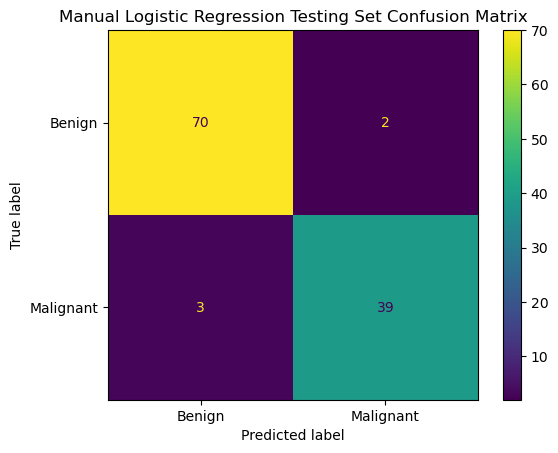

In [14]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Manual Logistic Regression Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Manual Logistic Regression Testing Set Confusion Matrix")

plt.show()

# Random Forest Classification

### Library Random Forest Classification

In [15]:
# applying python library random forest model to breast cancer data
model = RandomForestClassifier(max_depth=5)
model.fit(X_train_cancer, y_train_cancer)
y_train_prediction = model.predict(X_train_cancer)
y_test_prediction = model.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9934, Test accuracy: 0.9737

Train recall: 0.9824, Test recall: 1.0000

Train precision: 1.0000, Test precision: 0.9333


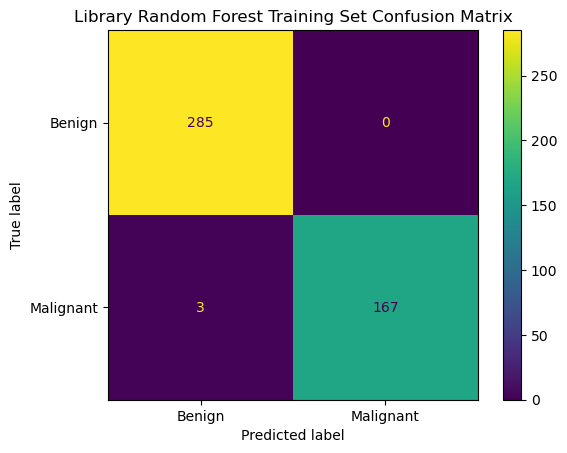

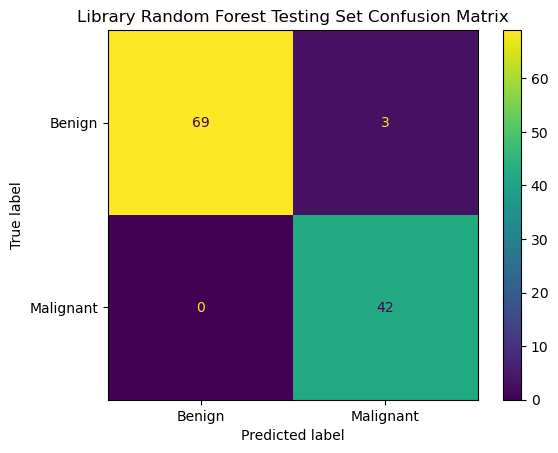

In [16]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Library Random Forest Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Library Random Forest Testing Set Confusion Matrix")

plt.show()

### Manual Random Forst Classification

In [17]:
class RandomForest:
    def __init__(self, num_trees=10, min_data_points_in_node=5, max_depth=5, num_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_data_points_in_node = min_data_points_in_node
        self.num_features = num_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for i in range(self.num_trees): # we create n trees
            tree = DecisionTree(max_depth=self.max_depth, min_data_points_in_node=self.min_data_points_in_node, num_features=self.num_features)
            X_sample, y_sample = self.get_samples(X, y) # each tree will get a random sample from the training data to train on
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def get_samples(self, X, y):
        num_samples = X.shape[0]
        random_indices = np.random.choice(num_samples, num_samples, replace=True)
        return X[random_indices], y[random_indices]

    def most_common_label(self, y):
        label_counts = {} # creating dictionary to store all label and their respective counts
        for label in y:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        most_common = None
        max_count = -1
        for label, count in label_counts.items(): # getting the label with the highest frequency
            if count > max_count:
                max_count = count
                most_common = label
        return most_common

    def predict(self, X):
        predictions = np.array([each_tree.predict(X) for each_tree in self.trees]) # gets predictions from each tree in the list
        tree_predictions = np.swapaxes(predictions, 0, 1)

        # for each data point, get the most common label predicted for that data point from all of the trees
        final_predictions = np.array([self.most_common_label(prediction) for prediction in tree_predictions])
        return final_predictions

In [18]:
# applying manual random forest model to breast cancer data
model = RandomForest(max_depth=5)
model.fit(X_train_cancer, y_train_cancer)
y_train_prediction = model.predict(X_train_cancer)
y_test_prediction = model.predict(X_test_cancer)

# getting train results
train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
train_recall = recall_score(y_train_cancer, y_train_prediction)
train_precision = precision_score(y_train_cancer, y_train_prediction)

# getting test results
test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
test_recall = recall_score(y_test_cancer, y_test_prediction)
test_precision = precision_score(y_test_cancer, y_test_prediction)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")

Train accuracy: 0.9912, Test accuracy: 0.9649

Train recall: 0.9765, Test recall: 1.0000

Train precision: 1.0000, Test precision: 0.9130


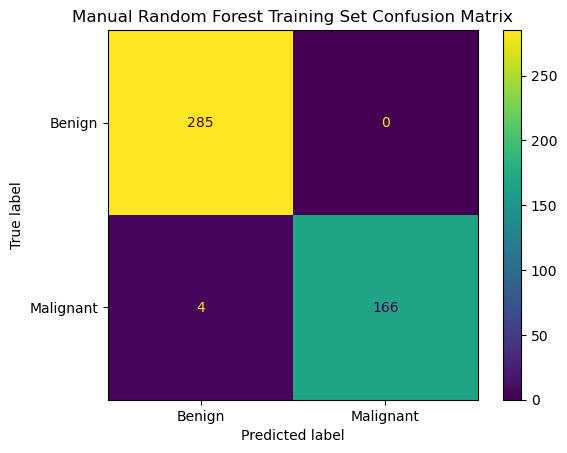

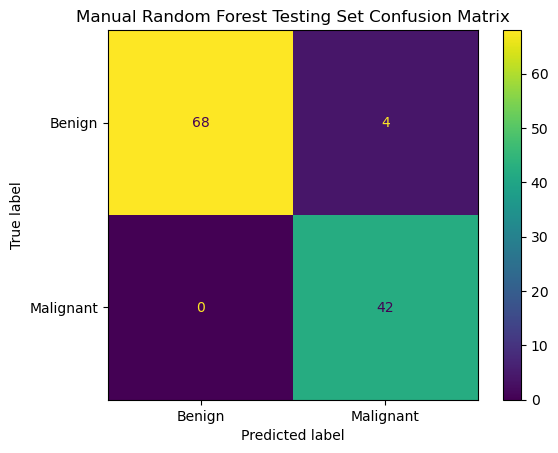

In [19]:
# creating confusion matrix for looking at data
train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
train_confusion_matrix_display.plot()
train_confusion_matrix_display.ax_.set_title("Manual Random Forest Training Set Confusion Matrix")

test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
test_confusion_matrix_display.plot()
test_confusion_matrix_display.ax_.set_title("Manual Random Forest Testing Set Confusion Matrix")

plt.show()

# Support Vector Machines (SVM)

In [20]:
# determining the train and test performance of a given SVM (support vector machine classifier) on breast cancer data
def svm_performance_on_cancer(svm, kernel_name):
    svm.fit(X_train_cancer, y_train_cancer)
    y_train_prediction = svm.predict(X_train_cancer)
    y_test_prediction = svm.predict(X_test_cancer)

    # getting train results
    train_accuracy = accuracy_score(y_train_cancer, y_train_prediction)
    train_recall = recall_score(y_train_cancer, y_train_prediction)
    train_precision = precision_score(y_train_cancer, y_train_prediction)
    
    # getting test results
    test_accuracy = accuracy_score(y_test_cancer, y_test_prediction)
    test_recall = recall_score(y_test_cancer, y_test_prediction)
    test_precision = precision_score(y_test_cancer, y_test_prediction)

    print(f"Kernel: {kernel_name}\n")
    print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}\n")
    print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}\n")
    print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}\n")
    
    return y_train_prediction, y_test_prediction

In [21]:
def svm_confusion_matrix_on_cancer(y_train_prediction, y_test_prediction, kernel_name, svm_type):
    # creating confusion matrix for looking at data
    train_confusion_matrix = confusion_matrix(y_train_cancer, y_train_prediction)
    train_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=["Benign", "Malignant"])
    train_confusion_matrix_display.plot()
    train_confusion_matrix_display.ax_.set_title(f"{svm_type} {kernel_name} Kernel SVM Training Set Confusion Matrix")
    
    test_confusion_matrix = confusion_matrix(y_test_cancer, y_test_prediction)
    test_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=["Benign", "Malignant"])
    test_confusion_matrix_display.plot()
    test_confusion_matrix_display.ax_.set_title(f"{svm_type} {kernel_name} Kernel SVM Testing Set Confusion Matrix")

### SVM with Python library

Kernel: Linear

Train accuracy: 0.9868, Test accuracy: 1.0000

Train recall: 0.9765, Test recall: 1.0000

Train precision: 0.9881, Test precision: 1.0000



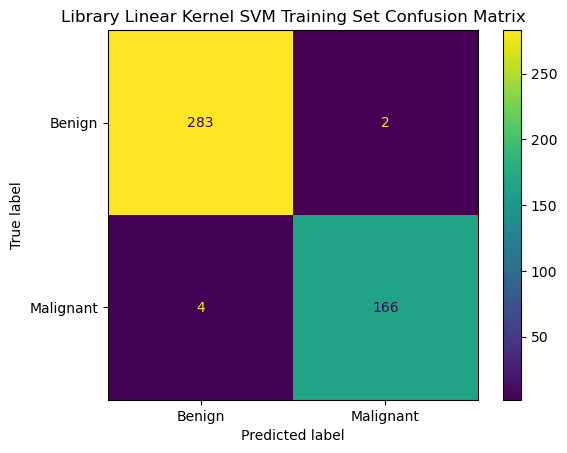

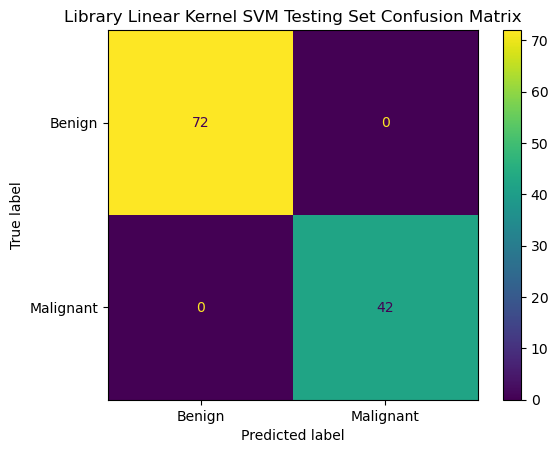

In [22]:
# using libsvm library
linear_svm = SVC(kernel='linear')
linear_y_train_prediction, linear_y_test_prediction = svm_performance_on_cancer(linear_svm, 'Linear')
svm_confusion_matrix_on_cancer(linear_y_train_prediction, linear_y_test_prediction, "Linear", "Library")
plt.show()

Kernel: RBF

Train accuracy: 0.9846, Test accuracy: 0.9825

Train recall: 0.9588, Test recall: 0.9762

Train precision: 1.0000, Test precision: 0.9762



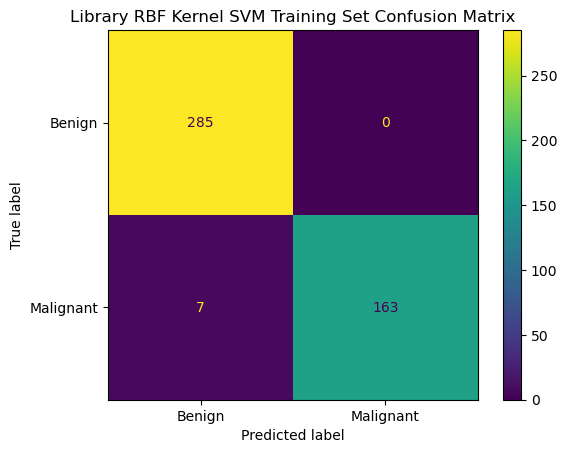

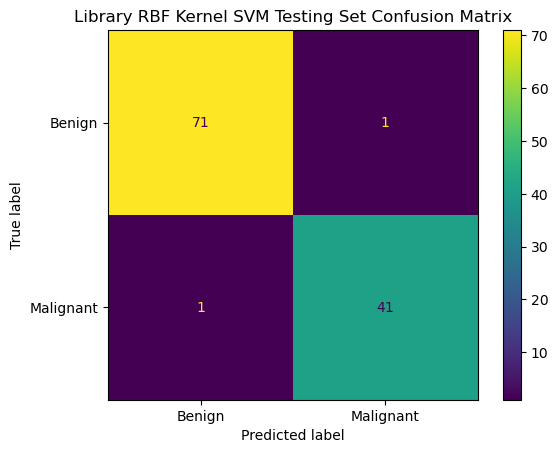

In [23]:
rbf_svm = SVC(kernel='rbf')
rbf_y_train_prediction, rbf_y_test_prediction = svm_performance_on_cancer(rbf_svm, 'RBF')
svm_confusion_matrix_on_cancer(rbf_y_train_prediction, rbf_y_test_prediction, "RBF", "Library")
plt.show()

Kernel: Polynomial Degree 2

Train accuracy: 0.8462, Test accuracy: 0.8070

Train recall: 0.6080, Test recall: 0.4167

Train precision: 0.9907, Test precision: 0.9375



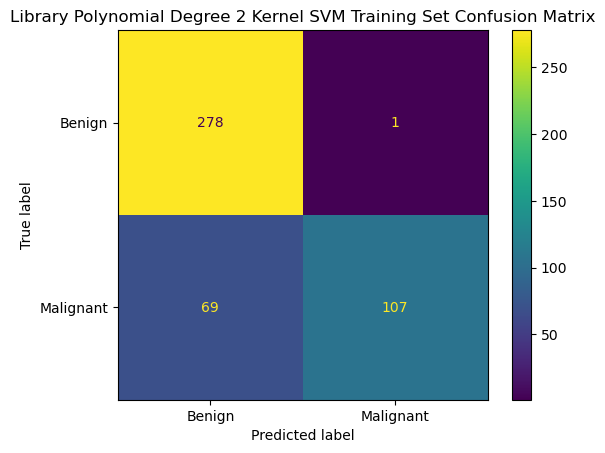

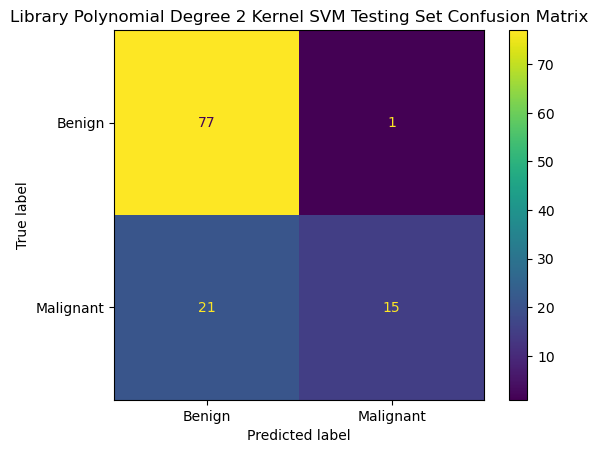

In [60]:
poly_svm = SVC(kernel='poly', degree=2)
poly_y_train_prediction, poly_y_test_prediction = svm_performance_on_cancer(poly_svm, 'Polynomial Degree 2')
svm_confusion_matrix_on_cancer(poly_y_train_prediction, poly_y_test_prediction, "Polynomial Degree 2", "Library")
plt.show()

### Manual SVM with SMO solver

In [24]:
class svm_with_smo_solver:
    # tolerance is error tolerance for convergence
    # max_iterations is max number of passes without convergence
    # C is regularization parameter
    # kernel is {'linear', 'rbf', 'poly', 'sigmoid'}
    # sigma is standard deviation of the gaussian in the rbf kernel
    # alpha is scaling parameter in the polynomial and sigmoid kernel
    # c is bias parameter in the polynomial and sigmoid kernel
    def __init__(self, tolerance=1e-3, max_iterations=100, C=1.0, kernel='linear', sigma=1.5, alpha=0.5, c=0.0, degree=3):
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.C = C
        self.bias = 0
        
        # setting up kernel and corresponding parameters based on input
        match kernel:
            case 'poly':
                self.kernel = self.polynomial_kernel
                self.alpha = alpha
                self.c = c
                self.degree = degree
            case 'rbf':
                self.kernel = self.rbf_kernel
                self.sigma = sigma
            case 'sigmoid':
                self.kernel = self.sigmoid_kernel
                self.alpha = alpha
                self.c = c
            case 'linear':
                self.kernel = self.kernel_linear

    # RBF (Radial Basis Function) kernel maps data into infinite gaussian space (good for nonlinear graphs)
    # more specifically, this is the Gaussian kernel
    # K(X, y) = e^(-1 * (|X - y|^2) / sigma^2)
    def rbf_kernel(self, X, y):
        if X.ndim == 1 and y.ndim == 1: # handle 2 vectors (both 1D arrays)
            return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X - y) ** 2)
        else: # handle multiple dimensional vectors
            return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - y[np.newaxis, :], axis=-1) ** 2)

    def polynomial_kernel(self, X, y):
        return ((self.alpha * X).dot(y.T) + self.c) ** self.degree
    
    # maps to 0-1 probability space like an activation function of a neuron (sigmoid kernel = s curve)
    # K(X, y) = tanh(alpha * X dot y^T + c)
    def sigmoid_kernel(self, X, y):
        return np.tanh((self.alpha * X).dot(y.T) + self.c)

    # dot product of X and y (linear kernel = straight line)
    # K(X, y) = X dot y
    def kernel_linear(self, X, y):
        return X.dot(y.T)

    # train SVM using SMO optimization
    def fit(self, X, y):
        num_data_points = X.shape[0]
        self.X = X
        self.y = y
        self.alphas = np.zeros((num_data_points, ))
        iterations = 0
        
        while iterations < self.max_iterations:
            num_changed_alphas = 0 # track the number of lagrangians optimized this iteration
            
            for i in range(num_data_points): # for each data point and it's lagrangian
                error_i = self.decision_function(X[i]) - y[i] # finding error for point i

                # if ith lagrangian doesn't satisfy KKT conditions within given tolerance, then we can optimize lagrangian
                # KTT conditions (Karush-Kuhn-Tucker): determine if a Lagrange multiplier alpha is optimal given the constraints
                if (y[i] * error_i < -self.tolerance and self.alphas[i] < self.C) or (y[i] * error_i > self.tolerance and self.alphas[i] > 0):
                    j = np.random.choice(np.delete(np.arange(num_data_points), i)) # pick random j != i
                    error_j = self.decision_function(X[j]) - y[j] # error for point j
                    
                    # store the ith and jth lagrangians before optimization
                    alpha_i_old = self.alphas[i]
                    alpha_j_old = self.alphas[j]

                    '''
                    If y(i) != y(j), lower_bound = max(0, alpha_j - alpha_i), upper_bound = min(C, C + alpha_j - alpha_i)
                    If y(i) = y(j), lower_bound = max(0, alpha_i + alpha_j - C), upper_bound = min(C, alpha_i + alpha_j)
                    modifying the lower and upper bounds of the new value of the Lagrange multiplier alpha
                    '''
                    if y[i] != y[j]:
                        lower_bound = max(0, self.alphas[j] - self.alphas[i])
                        upper_bound = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        lower_bound = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        upper_bound = min(self.C, self.alphas[i] + self.alphas[j])

                    # if the upper and lower bounds are equal, then skip modifying the new Lagrange multiplier alpha value
                    if lower_bound == upper_bound: 
                        continue

                    # optimize the jth lagrangian (trying to find second derivative of kernel model to optimize alphas)
                    second_derivative = 2 * self.kernel(X[i], X[j]) - self.kernel(X[i], X[i]) - self.kernel(X[j], X[j])

                    if second_derivative >= 0:
                        continue

                    self.alphas[j] -= (y[j] * (error_i - error_j) / second_derivative) # update alpha pair (SMO step)

                    # clip the new jth lagrangian between lower_bound and upper_bound of new alphas
                    self.alphas[j] = np.clip(self.alphas[j], lower_bound, upper_bound)

                    # if difference between new alpha and old alpha is too small to matter, then skip alpha pair
                    if abs(alpha_j_old - self.alphas[j]) < 1e-5:
                        continue

                    # optimize the ith lagrangian (only update 2 alphas at a time - can't be updated independently)
                    self.alphas[i] += (y[i] * y[j] * (alpha_j_old - self.alphas[j]))

                    # update bias - compute 2 new values for bias and update accordingly
                    b1 = self.bias - error_i - y[i] * (self.alphas[i] - alpha_i_old) * self.kernel(X[i], X[i]) - y[j] * (
                        self.alphas[j] - alpha_j_old) * self.kernel(X[i], X[j])
                    b2 = self.bias - error_j - y[i] * (self.alphas[i] - alpha_i_old) * self.kernel(X[i], X[j]) - y[j] * (
                        self.alphas[j] - alpha_j_old) * self.kernel(X[j], X[j])
                    if self.alphas[i] > 0 and self.alphas[i] < self.C:
                        self.bias = b1
                    elif self.alphas[j] > 0 and self.alphas[j] < self.C:
                        self.bias = b2
                    else:
                        self.bias = (b1 + b2) / 2

                    num_changed_alphas += 1

            # check for convergence (check if none of the alphas changed)
            if num_changed_alphas == 0:
                break
            else:
                iterations += 1

    # decision function for SMO
    # decision_function(X_i) = summation((alphas * y) dot kernel(X, X_i)) + bias
    def decision_function(self, X):
        return (self.alphas * self.y).dot(self.kernel(self.X, X)) + self.bias

    # classify each point as -1 or 1 based on the sign of the decision score
    # if decision_function(X_i) > 0, then point is classified as 1
    # if decision_function(X_i) < 0, then point is classified as -1
    def predict(self, X):
        return np.sign(self.decision_function(X))
        # return (self.decision_function(X) > 0.2).astype(int)

Kernel: Manual Linear

Train accuracy: 0.9714, Test accuracy: 0.9825

Train recall: 0.9824, Test recall: 1.0000

Train precision: 0.9435, Test precision: 0.9545



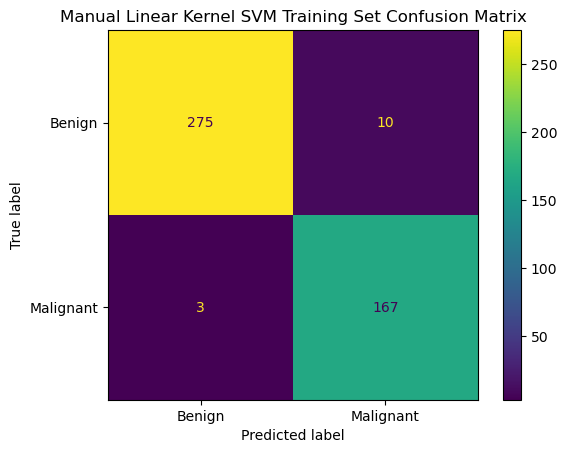

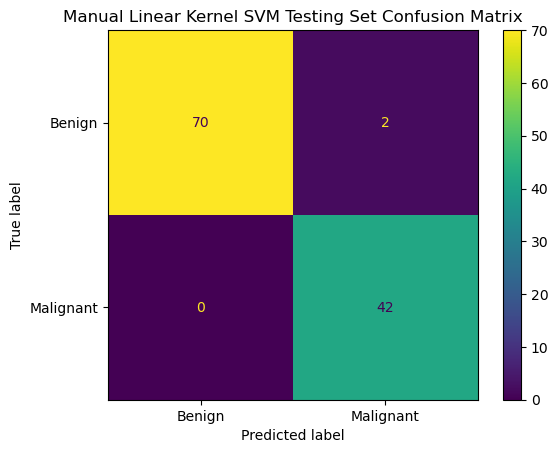

In [25]:
my_linear_svm = svm_with_smo_solver(kernel='linear')
linear_y_train_prediction, linear_y_test_prediction = svm_performance_on_cancer(my_linear_svm, 'Manual Linear')
svm_confusion_matrix_on_cancer(linear_y_train_prediction, linear_y_test_prediction, "Linear", "Manual")
plt.show()

Kernel: Manual RBF

Train accuracy: 0.9978, Test accuracy: 0.9035

Train recall: 0.9941, Test recall: 0.7381

Train precision: 1.0000, Test precision: 1.0000



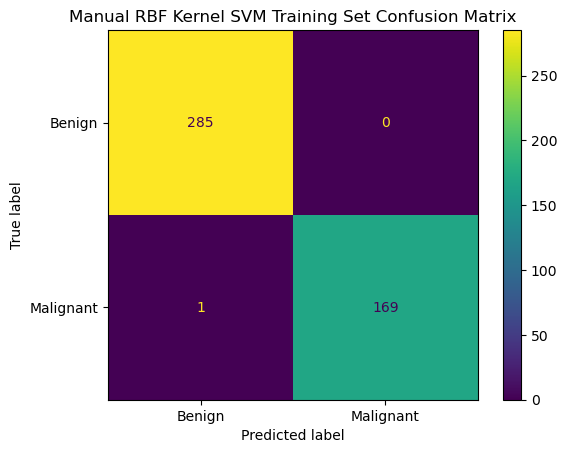

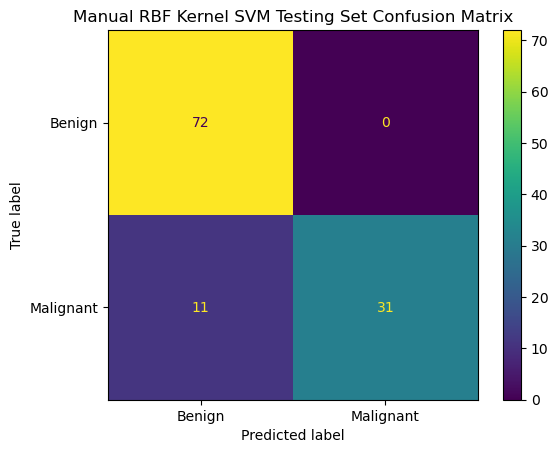

In [26]:
my_rbf_svm = svm_with_smo_solver(kernel='rbf')
rbf_y_train_prediction, rbf_y_test_prediction = svm_performance_on_cancer(my_rbf_svm, 'Manual RBF')
svm_confusion_matrix_on_cancer(rbf_y_train_prediction, rbf_y_test_prediction, "RBF", "Manual")
plt.show()

Kernel: Manual Polynomial Degree 2

Train accuracy: 0.9626, Test accuracy: 0.7895

Train recall: 0.9059, Test recall: 0.6190

Train precision: 0.9935, Test precision: 0.7647



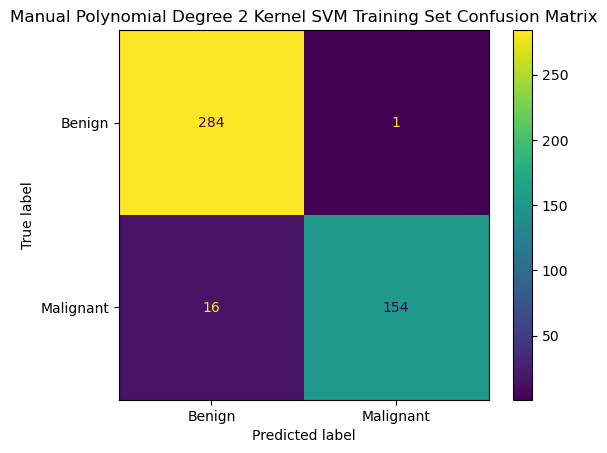

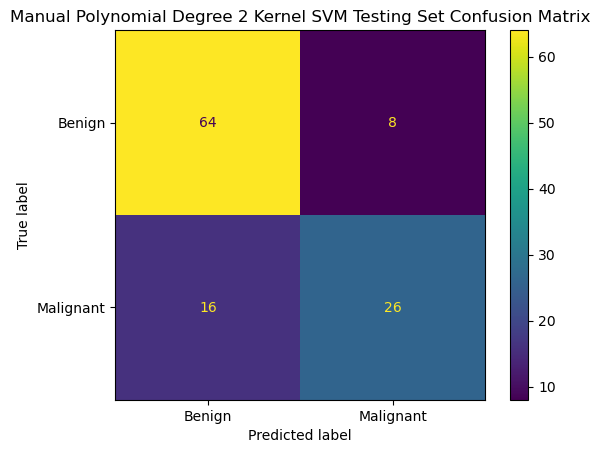

In [29]:
my_poly_svm = svm_with_smo_solver(kernel='poly', degree=2)
poly_y_train_prediction, poly_y_test_prediction = svm_performance_on_cancer(my_poly_svm, 'Manual Polynomial Degree 2')
svm_confusion_matrix_on_cancer(poly_y_train_prediction, poly_y_test_prediction, "Polynomial Degree 2", "Manual")
plt.show()

Kernel: Manual Sigmoid

Train accuracy: 0.8791, Test accuracy: 0.9211

Train recall: 0.7824, Test recall: 0.8810

Train precision: 0.8808, Test precision: 0.9024



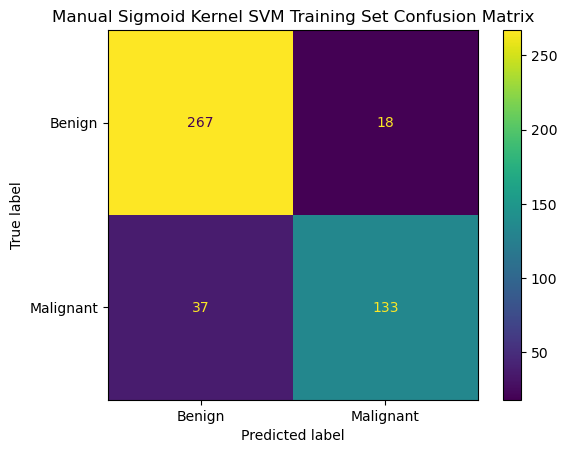

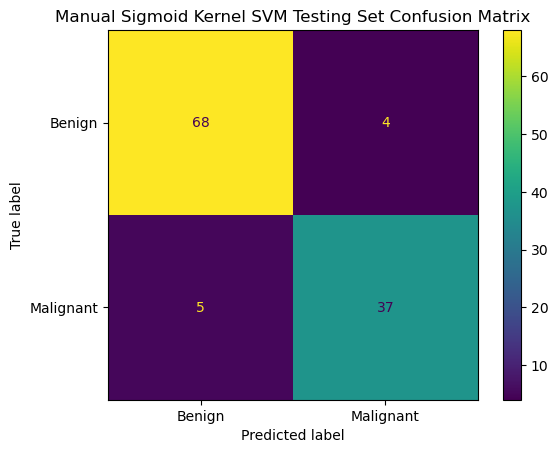

In [31]:
my_sigmoid_svm = svm_with_smo_solver(kernel='sigmoid')
sigmoid_y_train_prediction, sigmoid_y_test_prediction = svm_performance_on_cancer(my_sigmoid_svm, 'Manual Sigmoid')
svm_confusion_matrix_on_cancer(sigmoid_y_train_prediction, sigmoid_y_test_prediction, "Sigmoid", "Manual")
plt.show()